<a href="https://colab.research.google.com/github/brooksburkhead/capstone-project/blob/main/Inflection_Point_Plotting_Workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns

#Data Loading

In [2]:
from google.colab import auth
auth.authenticate_user()

In [3]:
%%bigquery full_data --project c11-capstone
SELECT COMMON_NAME, LATITUDE, LONGITUDE, OBSERVATION_DATE
FROM `c11-capstone.nm_ebird.ebd_NM_relSep_2023`
WHERE OBSERVATION_DATE BETWEEN '1990-01-01' AND '2022-12-31'

Query is running:   0%|          |

Downloading:   0%|          |

In [4]:
full_data.head()

,COMMON_NAME,LATITUDE,LONGITUDE,OBSERVATION_DATE
0,Pyrrhuloxia,32.115555,-103.188484,1994-03-26
1,Blue Jay,32.939261,-103.337520,2017-09-24
2,Domestic goose sp. (Domestic type),32.939261,-103.337520,2019-05-23
3,Scaled Quail,32.857101,-103.793807,2017-04-20
4,Ring-necked Duck,33.252272,-103.296955,2013-04-11


In [5]:
full_data.shape

(9009593, 4)

In [6]:
full_data.columns = full_data.columns.str.replace('_', ' ')

In [7]:
full_data.columns

Index(['COMMON NAME', 'LATITUDE', 'LONGITUDE', 'OBSERVATION DATE'], dtype='object')

In [8]:
full_data['OBSERVATION DATE'] = pd.to_datetime(full_data['OBSERVATION DATE'])

In [9]:
def add_datetime_components(df, datetime_column_name='OBSERVATION DATE'):
    '''Extracts components of a datetime column into new columns'''
    df['MONTH'] = df[datetime_column_name].dt.month
    df['YEAR'] = df[datetime_column_name].dt.year
    df['WEEK'] = df[datetime_column_name].dt.isocalendar().week
    df['DAY'] = df[datetime_column_name].dt.dayofyear

# Assuming full_data is your DataFrame
add_datetime_components(full_data)


In [10]:
full_data.head()

,COMMON NAME,LATITUDE,LONGITUDE,OBSERVATION DATE,MONTH,YEAR,WEEK,DAY
0,Pyrrhuloxia,32.115555,-103.188484,1994-03-26,3,1994,12,85
1,Blue Jay,32.939261,-103.337520,2017-09-24,9,2017,38,267
2,Domestic goose sp. (Domestic type),32.939261,-103.337520,2019-05-23,5,2019,21,143
3,Scaled Quail,32.857101,-103.793807,2017-04-20,4,2017,16,110
4,Ring-necked Duck,33.252272,-103.296955,2013-04-11,4,2013,15,101


In [11]:
full_data_copy = full_data.copy()

In [53]:
def plot_bird_data(data, bird_name, time = 'MONTH', deg = 6, floor = 0, ceiling = 365):
    """
    Automatically plots observations by month (over multiple years) for a bird species found in the
    ebird dataset.

    Then, for all the above plots, fits a polynomial, calculates the 2nd derivitive of each polynomial and find the inflection points.

    Then plots the fitted polynomials and the inflection points as vertical lines

    Optional parameter to change degree of fitted polynomials. Default = 6.

    """

    # Filter data for the specific bird
    bird_data = data[data['COMMON NAME'] == bird_name]

    if bird_data.empty:
        print(f"No data found for the bird: {bird_name}")
        return

    time_dict = {
                  'MONTH':   12,
                  'WEEK' :   52,
                  'DAY'  :   365,
                }

    if time not in time_dict.keys():
        print(f"No data found for the time period: {time}")
        return

    # Create a DataFrame similar to 'monthly_counts' for the specific bird
    global bird_monthly_counts
    bird_monthly_counts = bird_data.groupby(['YEAR', time]).size().reset_index(name='Observation Count')
    bird_monthly_counts[time] = bird_monthly_counts[time].astype('int64') #god i hate python sometomes...

    degree = deg  # You can change the degree of the polynomial

    global polynomials
    polynomials = []

    # Create a Plotly Express line plot
    fig = px.line(bird_monthly_counts, x= time, y='Observation Count', color='YEAR',
                  markers=True, title=f'Observation Count for {bird_name} by {time.title()} (Across Years)')

    #Calculate fitted polynomials for every year
    for year in bird_monthly_counts['YEAR'].unique():
        year_data = bird_monthly_counts[bird_monthly_counts['YEAR'] == year]
        coefficients = np.polyfit(year_data[time], year_data['Observation Count'], degree)
        polynomial = np.poly1d(coefficients)
        polynomials.append(polynomial)

        # Add the polynomial curve to the plot with dashed lines
        fig.add_scatter(x=year_data[time],
                        y=polynomial(year_data[time]),
                        mode='lines', line=dict(dash='dash'),
                        visible='legendonly',
                        name=f'Polynomial Approximation ({year})'
                        )

    # Calculate inflection points and filter out negative values and values outside the date range
    global inflection_points
    inflection_points = []

    for i, polynomial in enumerate(polynomials):
        year = bird_monthly_counts['YEAR'].unique()[i]
        year_color = fig['data'][i]['line']['color']  # Get the color of the corresponding year line

        # Calculate the 2nd derivative of the polynomial
        derivative = np.polyder(polynomial, m=2)

        # Find the roots (zeros) of the 2nd derivative, which correspond to inflection points
        roots = np.roots(derivative)

        # Select real roots (ignore complex roots) and filter out negative or >12 inflection points

        #real_roots = [root.real for root in roots if np.isreal(root) and 0 <= root <= time_dict[time]]
        #Create  'window' of inflection points of interest
        real_roots = [root.real for root in roots if np.isreal(root) and floor <= root <= ceiling]


        # Add the filtered inflection points to the list
        inflection_points.extend((inflection_point, year, year_color) for inflection_point in real_roots)

    # Plot vertical lines at inflection points
    for inflection_point, year, year_color in inflection_points:
        inflection_trace = go.Scatter(
            x=[inflection_point, inflection_point],
            y=[0, max(bird_monthly_counts['Observation Count'])],
            mode='lines',
            line=dict(color=year_color, dash="dash"),
            name=f'Inflection Point ({year})',
            visible='legendonly'  # Initially set to be hidden
        )
        fig.add_trace(inflection_trace)

    # Show the plot
    fig.show()




In [57]:
plot_bird_data(full_data_copy, 'Sandhill Crane', time = 'WEEK', deg = 6, floor = 26, ceiling= 43 )

In [48]:
bird_monthly_counts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 957 entries, 0 to 956
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   YEAR               957 non-null    int64
 1   WEEK               957 non-null    int64
 2   Observation Count  957 non-null    int64
dtypes: int64(3)
memory usage: 22.6 KB


In [50]:
def search_name(data, col, name: str) -> pd.core.frame.DataFrame:
  '''use this tool to search for entry in df'''
  return data[data[col].str.contains(name)]

In [51]:
search_name(full_data_copy, 'COMMON NAME', 'Mallard')['COMMON NAME'].value_counts()

Mallard                                105215
Mallard/Mexican Duck                    38198
Mallard x Mexican Duck (hybrid)          4603
Mallard x Northern Pintail (hybrid)        18
American Wigeon x Mallard (hybrid)          2
Gadwall x Mallard (hybrid)                  1
Name: COMMON NAME, dtype: int64

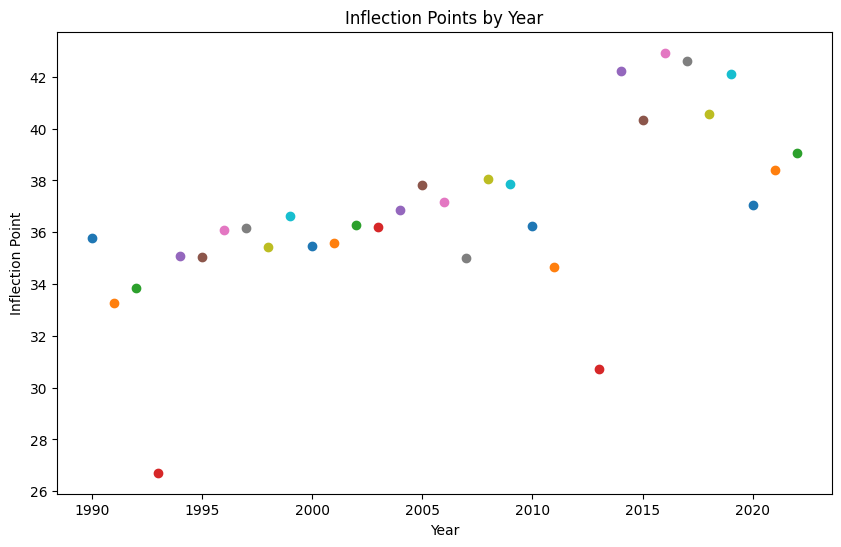

In [58]:
#PLEASE DO NOT THE CODE #PLEASE DO NOT THE CODE #PLEASE DO NOT THE CODE #PLEASE DO NOT THE CODE
#PLEASE DO NOT THE CODE #PLEASE DO NOT THE CODE #PLEASE DO NOT THE CODE #PLEASE DO NOT THE CODE
import matplotlib.pyplot as plt

# Function to extract inflection points for a specific year
def get_inflection_for_year(year, inflection_points):
    return [inflection_point for inflection_point, inflection_year, _ in inflection_points if inflection_year == year]

# List of years
years = bird_monthly_counts['YEAR'].unique()

# List to store inflection points for each year
inflection_points_by_year = [get_inflection_for_year(year, inflection_points) for year in years]

# Scatter plot
plt.figure(figsize=(10, 6))

for i, year in enumerate(years):
    plt.scatter([year] * len(inflection_points_by_year[i]), inflection_points_by_year[i], label=f'Year {year}')


plt.xlabel('Year')
plt.ylabel('Inflection Point')
plt.title('Inflection Points by Year')#
#plt.legend()
plt.show()


In [59]:
#PLEASE DO NOT THE CODE#PLEASE DO NOT THE CODE#PLEASE DO NOT THE CODE#PLEASE DO NOT THE CODE#PLEASE DO NOT THE CODE#PLEASE DO NOT THE CODE
#PLEASE DO NOT THE CODE#PLEASE DO NOT THE CODE#PLEASE DO NOT THE CODE#PLEASE DO NOT THE CODE#PLEASE DO NOT THE CODE#PLEASE DO NOT THE CODE

# Function to extract inflection points for a specific year
def get_inflection_for_year(year, inflection_points):
    return [inflection_point for inflection_point, inflection_year, _ in inflection_points if inflection_year == year]

# List of years
years = bird_monthly_counts['YEAR'].unique()

# List to store inflection points for each year
inflection_points_by_year = [get_inflection_for_year(year, inflection_points) for year in years]

# Create a list of dictionaries for Plotly Express
scatter_data = []
for i, year in enumerate(years):
    for inflection_point in inflection_points_by_year[i]:
        scatter_data.append({'Year': year, 'Inflection Point': inflection_point})

# Create a scatter plot using Plotly Express with a trendline
fig = px.scatter(scatter_data, x='Year', y='Inflection Point', color='Year', title='Inflection Points by Year',
                 trendline='ols')  # Ordinary Least Squares (OLS) regression trendline
fig.show()
